**Introduction**: (Ignore hidden/commented markdown cells ) \
(Also note that some printouts in the code may contradict what I wrote in the PDF because I've ran them again in the code for submission since I commented them in the PDF for space)

We're using the UCI Credit Approval Dataset https://archive.ics.uci.edu/dataset/27/credit+approval and we'll build a Logistic Regression Model that generalizes well and can be used to classify whether if a person applying for credit will be aproved or not in a relatively accurate manner. We're using Logistic Regression because it does a good enough job for models that have binary target variables that's 0 or 1 (rejected or approved for credit)

I'm interested in this topic because I'm interested in finance and credit is very important in facilatitating business transactions, consumer spending, investments, and so on.

**Preparing the dataset before training**:

In [33]:
## Imports (make sure to have these installed, use "pip install <name>") 
# Read the data file
import pandas as pd
df = pd.read_csv('./crx.data', header=None, na_values="?") 
# optional: can use the url instead if file doesn't work
# url = "https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data"
import numpy as np # optional: autograd.numpy (not needed for our purposes right now)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, ReLU, LayerNormalization, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency
import seaborn as sns

In [34]:
# Assign columns A1 to A16
df = pd.read_csv('./crx.data', header=None, na_values="?")
df.columns = [f"A{i+1}" for i in range(df.shape[1])]
categorical_preview_cols = df.select_dtypes(include=['object']).columns.tolist()

# Strip and map only valid class values and map +/- into 1/0
df["A16"] = df["A16"].astype(str).str.strip().map({'+': 1, '-': 0})
print("\n",df.shape[0], "rows ×", df.shape[1], "columns")


 690 rows × 16 columns


In [35]:
# Check how many Missing (NaN) values rows there are for each column/predictor variables
df_nas = df.isna().sum()
print(df_nas[df_nas>0]) # commented to save space
# we only lose at least 13 out of 690 rows that have missing values, so we drop them
df_clean = df.dropna()
print("\n",df_clean.shape[0], "rows ×", df_clean.shape[1], "columns")
df_clean.head() # # commented to save space

A1     12
A2     12
A4      6
A5      6
A6      9
A7      9
A14    13
dtype: int64

 653 rows × 16 columns


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,1
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,1


In [36]:
# Count rows with *any* NA (for overlaps)
print("Number of NA rows = ", df.isna().any(axis=1).sum())
# Check NaN distributions by target class (0 or 1)
print(df[df.isna().any(axis=1)]['A16'].value_counts()) # # commented to save space

Number of NA rows =  37
A16
0    26
1    11
Name: count, dtype: int64


In [37]:
# Class distribution before dropping NAs
print("Before dropping NAs:")
print(df['A16'].value_counts())

# Class distribution after dropping NAs
print("\nAfter dropping NAs:")
print(df.dropna()['A16'].value_counts()) # # Commented to save space

Before dropping NAs:
A16
0    383
1    307
Name: count, dtype: int64

After dropping NAs:
A16
0    357
1    296
Name: count, dtype: int64


By checking class distributions (commented to save space, check code), we see that 26 0's and 11 1's are dropped (37 rows / 690 rows = approx 5.36%) \
Dropping NA's cause very minimal shift toward approvals. Likely acceptable to drop NaN rows for most models. Since the class shift is negligible after dropping NaN rows, dropping NAs is simpler for our model building hereon out.

In [38]:
# If keeping the dropped version (653 rows)
df_clean = df.dropna()
# Numeric columns & Categorical columns 
num_cols = ['A2', 'A3', 'A8', 'A11', 'A14', 'A15']; cat_cols = ['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13']

In [39]:
## To further justify dropping, we first check distributions of classes before and after
# Check distribution after dropping NA's
print(df['A16'].value_counts(normalize=True)) ## commented to save space

A16
0    0.555072
1    0.444928
Name: proportion, dtype: float64


In [5]:
df_clean = df.dropna()
print(df_clean['A16'].value_counts(normalize=True))

A16
0    0.546708
1    0.453292
Name: proportion, dtype: float64


In [6]:
# Drop rows with NAs
df_clean = df.dropna().copy()  # Now has 653 rows (from 690)
# Separate features (X) and target (y)
X = df_clean.drop('A16', axis=1)  # All predictor columns
y = df_clean['A16']              # Target (0=denied, 1=approved)

In [7]:
# X.dtypes # uncomment if needed

To preprocess our data we use One-Hot Encoding to include categorical variables. Categorical Columns (based on UCI dataset description): \
A1, A4, A5, A6, A7, A9, A10, A12, A13. (Note: Verify by checking dtypes with X.dtypes for "object" dtypes).
One-hot encoding creates binary (0/1) features for each category and we use drop='first' to drop the first binary column in order to avoid multicollinearity.

In [8]:
# Categorical columns (adjust based on your dataset) & Numeric columns (standardize later)
categorical_cols = ['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13']; numeric_cols = X.columns.difference(categorical_cols).tolist()

# ColumnTransformer for encoding categoricals and keep numericals unchanged/untransformed.
preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(drop='first'), categorical_cols),
        ('num', 'passthrough', numeric_cols)])
X_processed = preprocessor.fit_transform(X)

We standardize numeric features to ensure equal feature scaling of the numeric features, since some features may be large such as for example income, etc. that often have different units in the thousands, even hundreds of thousands. Standardizing puts them on the same scale (mean=0, std=1), in order to prevent features with larger magnitudes from dominating the model. \
Also, models like neural networks use gradient descent, which converges faster when features are standardized.

In [9]:
# Standardize numeric features (after one-hot encoding)
scaler = StandardScaler()
X_processed[:, len(preprocessor.named_transformers_['cat'].get_feature_names_out()):] = \
    scaler.fit_transform(X_processed[:, len(preprocessor.named_transformers_['cat'].get_feature_names_out()):])

**Train-Test Split**:

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.3, random_state=69, stratify=y) 
# stratify = y is to evenly distribute the values of y in each split.

**Build the initial Neural Network on the whole dataset using all variables & Train the initial Model**:\
1st hidden layer: 64 neurons ReLU activation function to learn complex patterns from input features. \
2nd hidden layer: 32 neurons ReLU to refine the learned representations. \
Both with 30% Dropout, which randomly sets 30% of the layer's outputs to 0 during training. We use a moderate 30% to prevent overfitting to training data noise, any higher would risk underfitting and any lower may not prevent overfitting.\
Sigmoid activation in the outer layer, which makes the outputs to [0,1] range, which is what we need for binary classification (credit approval: 0=reject, 1=approve). OPTONAL: We refrain from using normalization since Loss and accuracy seems relatively stable without it. \
Our model has:
1st Hidden layer for processing the input data (aka. Input layer): 64 neurons [ expecting 37 features, so 2432 params = (37 inputs * 64 neurons) + 64 biases ] \
2nd Hidden layer: 32 neurons, so 2080 params = (64 inputs * 32 neurons) + 32 biases \
Output Layer: 1 neuron, so 33 params = 32 inputs * 1 neuron + 1 Bias (sigmoid for binary classification)\
Total params: 4,545

We use learning rate = 0.001 since it is the standard initial learning rate for the Adam optimizer because it’s small enough to avoid overshooting optimal weights (divergence) and large enough to make meaningful progress without being impractically slow. Can Decrease if loss oscillates or diverges.\
And we use binary_crossentropy to measure the difference between predicted probabilities (sigmoid outputs) and true binary labels (0 or 1).

**For training**:\
To prevent overfitting we use EarlyStopping to stop training when the model stops improving on validation data. \
Key Parameters:\
patience=5: the model will wait and run for 5 epochs without improvement before stopping the training. It monitors val_loss by default (or another metric if specified). If there's no improvement for 5 patience epochs, training will stop. \
restore_best_weights=True: Revert to the model weights from the epoch with the best validation performance when we do stop training.

We choose a reasonable 50 epochs for a small to medium sized dataset, this is sufficient for convergence without overfitting. \
And 32 batch size as smaller batches offer more frequent updates, helping your model escape poor local minima, 32 is best balance of stability and efficiency as it has smoother gradients than lower batch sizes, i.e. faster convergence as it handles noise better, although it comes at a slightly higher risk of overfitting. 16 would be better for smaller datasets and more complex models, whereas 32 is fine for medium sized and simpler models.\
And we address the class imbalance during training by making the model pay more attention to the under-represented class using `class_weight={0: 0.55, 1: 0.45}`, since otherwise the model may be biased towards one class. Weights adjust the loss function to penalize errors on the minority class more heavily.

In [11]:
# Get input shape (number of features after encoding)
input_shape = X_train.shape[1]
model = Sequential([
    Dense(64, activation='relu', input_shape=(input_shape,)),Dropout(0.3),  # Reduce overfitting
    Dense(32, activation='relu'), Dropout(0.3), Dense(1, activation='sigmoid')  # Binary classification
])
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)
callbacks = [EarlyStopping(patience=5, restore_best_weights=True)]    
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, class_weight={0: 0.55, 1: 0.45},
                    callbacks = callbacks, verbose = 0 ) # class_weight to adjust for class imbalance

<!-- ### OPTIONAL (IGNORE THIS): Layer Normalization vs Batch Normalization, (here in this small sample size Layer Norm > Batch Norm)


# # Get input shape (number of features after encoding)
# input_shape = X_train.shape[1]

# model = Sequential([
#     Dense(64, activation='relu', input_shape=(input_shape,)),
#     # LayerNormalization(),  # Safer than BatchNorm here
#     Dropout(0.3),  # Reduce overfitting
    
#     Dense(32, activation='relu'),
#     # LayerNormalization(),  # Safer than BatchNorm here
#     Dropout(0.3), 
#     Dense(1, activation='sigmoid')  # Binary classification
# ])

# # Compile the model
# model.compile(
#     optimizer=Adam(learning_rate=0.001),
#     loss='binary_crossentropy',
#     metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
# )

# model.summary()




# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, ReLU
# from tensorflow.keras.optimizers import Adam
# import tensorflow as tf

# model = Sequential([
#     Dense(64, use_bias=False, input_shape=(X_train.shape[1],)),
#     BatchNormalization(),
#     ReLU(),  # Explicit ReLU layer
#     Dropout(0.3),
    
#     Dense(32, use_bias=False),
#     BatchNormalization(),
#     ReLU(),
#     Dropout(0.3),
    
#     Dense(1, activation='sigmoid')
# ])

# # Compile with Adam optimizer and metrics
# model.compile(
#     optimizer=Adam(learning_rate=0.001),
#     loss='binary_crossentropy',
#     metrics=[
#         'accuracy',
#         tf.keras.metrics.AUC(name='auc')  # For credit risk evaluation
#     ]
# )
# # Model summary
# model.summary() -->

<!-- (IGNORE) #### Plot Training History
 -->

<!-- (IGNORE) #### Comments:
Initial sharp increase in improvement of accuracy where there's rapid learning of easy patterns (such as very obvious and clear-cut approval/rejection cases). Then after a few epochs we have gradual increase : where the model learns finer, more complex patterns. The convergence of the gap between training and validation(test) accuracy after a certain number of epochs implies reduced overfitting as the model stabilizes, the initial divergence in gap of accuracy is normal as the model transitions from memorizing noise to learning generalizable patterns.

Loss seems stable and steady, accuracy is somewhat erratic/rough (not very smooth) due to slight fluctuations due to randomness but it's still relatively stable enough to learn patterns to generalize well. -->

**Evaluate the Model**:

In [12]:
# Evaluate on test data
loss, accuracy, auc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")
print(f"AUC: {auc:.2f}")  # AUC > 0.8 is good, ideally we want > 0.9 which is excellent
# Predictions
y_pred = (model.predict(X_test) > 0.5).astype(int) # threshold > 0.5 default for binary classifications

7/7 [==============================] - 0s 872us/step - loss: 0.2986 - accuracy: 0.8622 - auc: 0.9454
Test Accuracy: 0.86
AUC: 0.95
7/7 [==============================] - 0s 568us/step


**Comment**:
AUC = 0.9454 > 0.9: Excellent at discriminating between the two classes  (far better than random guessing (0.5)). Test Accuracy approx. 86%: Good, Model generalizes well to unseen data. May be possible to optimize further.

In [13]:
# Get weights from the first dense layer
weights = model.layers[0].get_weights()[0]  # Shape: (n_features, 64)
avg_impact = np.mean(np.abs(weights), axis=1)
# Get feature names (after one-hot encoding)
feature_names = np.concatenate([preprocessor.named_transformers_['cat'].get_feature_names_out(), numeric_cols])

In [40]:
# Note that These average weights can change after each run of the model
# these are ran again after the PDF is submitted, so that's why the values are different.
pd.DataFrame({'Feature': feature_names[:len(avg_impact)],'Avg_Weight': avg_impact}).sort_values('Avg_Weight',ascending=False).head(10) ## commented to save space

,Feature,Avg_Weight
9,A6_ff,0.153485
26,A9_t,0.150752
17,A6_x,0.146062
14,A6_q,0.143671
36,A8,0.138639
8,A6_e,0.136658
23,A7_o,0.136567
10,A6_i,0.135137
20,A7_h,0.134986
12,A6_k,0.134295


<!-- (IGNORE) 1. Interpreting Your Results
Test Accuracy: 0.88 → Model generalizes well to unseen data.

AUC: 0.95 → Near-perfect class separation (anything >0.9 is outstanding).

Training/Validation Curves:

Initial divergence (epochs 1-10) is normal (model learns training patterns first).

Later convergence shows dropout/early stopping prevented overfitting.

2. Why Initial Curves Diverge
Early Epochs: The model learns coarse patterns from training data first, before adapting to validation nuances.

Later Epochs: Dropout (0.3) regularizes the network, forcing it to rely on robust features shared across both sets.

Action: No fix needed—this is expected behavior. -->

<!--(IGNORE) 2. Key Observations from Your Training
Metric	Epoch 1	Epoch 34 (Best)	Notes
Train Acc	53.8%	88.3%	Model learned well on training data.
Val Acc	65.7%	87.8%	Validation accuracy plateaued.
Val AUC	0.73	0.948	Near-perfect separation (AUC > 0.9 is excellent).
Stopping Point: Ideal. The model reached peak validation performance without overfitting.

5. Final Notes
Your model is well-trained (AUC 0.948 is excellent).

Early stopping did its job: Prevented overfitting and saved time.

Next Steps:

Evaluate on a held-out test set.

Use model.predict() for new data.

 -->

 <!-- (IGNORE) Are 88.3% Training and 87.8% Validation Accuracy Good?
Yes, these metrics are excellent. Here’s why:
Initial sharp increase in improvement of accuracy where there's rapid learning of easy patterns (such as very obvious and clear-cut approval/rejection cases). Then after a few epochs we have gradual increase : where the model learns finer, more complex patterns. The convergence of the gap between training and validation(test) accuracy after a certain number of epochs implies reduced overfitting as the model stabilizes, the initial divergence in gap of accuracy is normal as the model transitions from memorizing noise to learning generalizable patterns.

Loss seems stable and steady, accuracy is somewhat erratic/rough (not very smooth) due to slight fluctuations due to randomness but it's still relatively stable enough to learn patterns to generalize well.
Minimal Overfitting: The gap between training and validation accuracy is tiny (0.5% difference), indicating your model generalizes well.

Strong Performance: For credit approval (a noisy real-world problem), ~88% accuracy and AUC 0.948 are highly competitive.

Comparison:

Random guessing: 50% accuracy (binary classification).

Baseline models (e.g., logistic regression): Typically achieve 80–85% on this dataset.

 -->

<!-- (IGNORE) # This is for the plot of the initial model
plt.figure(figsize=(12, 5)) # Accuracy Plot
plt.subplot(1, 2, 1)  # 1 row, 2 cols, position 1
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2) # Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show() -->

So far we trained on ALL of the variables, now let's check the Variable Importance OR Signifcance to see which variables we can drop from training to see if we can simplify the model more. \
We can check this by finding which features have larger absolute weights, therefore contribute more vs which have lower absolute weights, i.e. contribute less.

Top & Bottom Features (High & Low Avg_Weight) (some of these are likely to change when re-running the model): 
the top features above strongly influence the model’s predictions. For example: A9_t (Likely Employment Status: "t" category) has the highest impact. \
Bottom Features (Low Avg_Weight) contribute minimally to predictions (but may still have subtle effects).\
Numeric Features: such as num__A15 are moderately important.

We Also want to check Correlation Analysis (Numerical Features)
First, let’s check correlations between numeric variables and the target (A16):

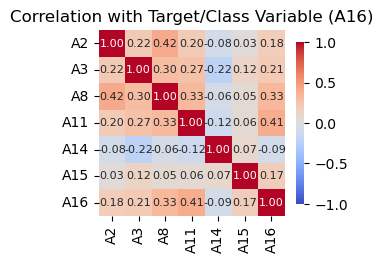

In [14]:
# print("Columns in df_clean:", df_clean.columns.tolist())  # Should include 'A16'
# Select numeric features (adjust based on your dataset)
numeric_cols = ['A2', 'A3', 'A8', 'A11', 'A14', 'A15']  # Numeric columns
df_numeric = df_clean[numeric_cols + ['A16']]  # Use 'A16' as target name
# Calculate correlations
corr_matrix = df_numeric.corr()
# Plot heatmap
plt.figure(figsize=(3, 3))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1,fmt=".2f",annot_kws={"size": 8},  # Smaller annotation text,
            cbar_kws={"shrink": 0.7},  # Smaller color bar, 
            square=True  # Makes cells square (more compact)
           )
plt.title("Correlation with Target/Class Variable (A16)")
plt.show()

In [41]:
# Get correlation of all numeric features with the target (A16)
target_correlations = corr_matrix['A16'].drop('A16')  # Remove self-correlation
# # Convert to a clean DataFrame
corr_df = pd.DataFrame({'Feature': target_correlations.index,'Correlation_with_Target': target_correlations.values}).sort_values('Correlation_with_Target', ascending=False)
print(corr_df.to_markdown(index=False)) # commented to save space

| Feature   |   Correlation_with_Target |
|:----------|--------------------------:|
| A11       |                 0.406052  |
| A8        |                 0.332728  |
| A3        |                 0.207086  |
| A2        |                 0.180252  |
| A15       |                 0.172766  |
| A14       |                -0.0852168 |


Interpretation of our feature Correlation with the target variable (A16) Results: \
Higher values = more approval.
A11 has strongest positive relationship, we Keep this. A8 has Moderate positive impact, 2nd strongest, we also Keep this. A3 and A2 has Weak positive influence. need to investigate further (may or may not keep). \
A15 also has weak positive influence. Low priority (we'll consider dropping this as well). A14 has Negligible negative impact. We'll most likely drop this.\
Recommended features to keep: A11 (Strongest predictor), A8 (High impact), A3 (Borderline; may or may not keep depending on model performance)\
Drop: A14 (Near-zero correlation), A2 and A15 (Weak correlations, unless prior knowledge about the feature/variable suggests otherwise) \
Retraining the simpler Model with fewer selected features will give us faster training + easier interpretation, and better gneralization: i.e. removing noise (especially A14) improves robustness.

In [16]:
selected_features = ['A11', 'A8', 'A3']  # Add categorical features later
X_selected = df_clean[selected_features]; categorical_cols = ['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13']

Checking Correlations for Categorical Variables\
Since categorical features (like A1, A4, A7, etc.) are non-numeric, we use target encoding (mean approval rate per category) or statistical tests (Chi-square, Cramer’s V) to measure their relationship with the target (A16). Here’s how to do it:\
Target Encoding (Approval Rate per Category)
For each categorical feature, calculate the mean approval rate (A16) for each category. This shows which categories strongly predict approval/denial.

In [42]:
# # List of categorical columns (adjust based on your dataset)
# THESE values maybe different from expalanations of Markdown cells below,
# this is because this was ran after the PDF
categorical_cols = ['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13']
for col in categorical_cols: # Commented to save space
    approval_rate = df_clean.groupby(col)['A16'].mean().sort_values(ascending=False)
    print(f"\n{col}: " + ", ".join([f"{k}={v:.1%}" for k, v in approval_rate.items()]))
print('\n',df.dropna()['A16'].value_counts(normalize = True)) # Commented to save space


A1: a=46.8%, b=44.7%

A4: l=100.0%, u=49.9%, y=29.6%

A5: gg=100.0%, g=49.9%, p=29.6%

A6: x=83.3%, cc=72.5%, r=66.7%, q=65.3%, e=58.3%, w=52.4%, c=45.1%, m=42.1%, aa=36.5%, j=30.0%, k=27.1%, d=26.9%, i=25.5%, ff=14.0%

A7: z=75.0%, h=63.5%, n=50.0%, o=50.0%, bb=45.3%, v=42.8%, j=37.5%, dd=33.3%, ff=14.8%

A9: t=79.7%, f=5.9%

A10: t=70.7%, f=25.4%

A12: t=48.0%, f=43.0%

A13: p=50.0%, g=46.8%, s=28.3%

 A16
0    0.546708
1    0.453292
Name: proportion, dtype: float64


<!-- # # Calculate approval rate per category
# for col in categorical_cols:
#     approval_rates = df_clean.groupby(col)['A16'].mean().sort_values(ascending=False)
#     print(f"\nApproval Rate by {col}:")
#     print(approval_rates.to_markdown())
 -->

**Interpretation**:
Categories with approval rates far from the cleaned dataset mean (~45.3%) are influential.

Example: A9_t has 79.7% approval, A10_t has 70.7% approval (verify on code printouts), etc. therefore A9 and A10 is a critical feature.

**Key Insights from Target Encoding**
**Focus on features where:**  
- Approval rates differ by a conservative amount of **>15%** from the cleaned dataset mean (45.3%), and High variance between categories (compare with print outs in code).   
| Feature | Key Categories | Severity of Approval Rate | Variance from Mean | Decision |  
|---------|----------------|---------------|--------------------|----------|  
| **A4**  | `l` (100%) vs `y` (29.6%) | Extreme       | +54.7% / -15.7%    | Keep     |  
| **A5**  | `gg` (100%) vs `p` (29.6%) | Extreme       | +54.7% / -15.7%    | Keep     |  
| **A6**  | `x` (83.3%) vs `ff` (14.0%) | High         | +38.0% / -31.3%    | Keep     |  
| **A7**  | `z` (75.0%) vs `ff` (14.8%)   | High         | +29.7% / -30.5%    | Keep     |  
| **A9**  | `t` (79.7%) vs `f` (5.9%)   | High      | +34.4% / -39.4%    | Keep     |  
| **A10** | `t` (70.7%) vs `f` (25.4)  | High         | +25.4% / -19.9%    | Keep     |  
| **A1**  | `a` (46.8%) vs `b` (44.7%)  | Minimal      | +1.5% / -0.6%      | Drop     |  
| **A12** | `t` (48.0) vs `f` (43.0%)      | Minimal      | +2.7% / -2.3%      | Drop     |  
| **A13** | `p` (50%) vs `s` (28.3%)    | Moderate     | +4.7% / -17.0%     | Borderline |  

Next, Chi-Square Test (Statistical Significance)
Tests whether a categorical feature and the target are independent.

In [18]:
for col in categorical_cols:
    contingency_table = pd.crosstab(df_clean[col], df_clean['A16'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    print(f"{col}: p-value = {p:.4f}")

A1: p-value = 0.6734
A4: p-value = 0.0000
A5: p-value = 0.0000
A6: p-value = 0.0000
A7: p-value = 0.0000
A9: p-value = 0.0000
A10: p-value = 0.0000
A12: p-value = 0.2305
A13: p-value = 0.0341


Cramer’s V (Strength of Association)
Measures correlation strength between 0 (no association) and 1 (perfect association). \
Key points: p-value < 0.05: The feature and target are correlated (significant). p-value > 0.05: No evidence of correlation.

**Chi-Square Test Results**  
- **Highly Significant (p < 0.001):**  
  `A4`, `A5`, `A6`, `A7`, `A9`, `A10` → Strong statistical relationship with approval.  Keep these.
- **Not Significant (p > 0.05):**  
  `A1`, `A12` → No evidence of relationship. Drop these.
- **Marginally Significant:**  
  `A13` ( p = 0.0341) → Somewhat significant to Weak relationship. May or may not keep.

In [19]:
def cramers_v(contingency_table):
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    return np.sqrt(phi2 / min(k-1, r-1))
    
for col in categorical_cols:
    contingency_table = pd.crosstab(df_clean[col], df_clean['A16'])
    print(f"{col}: Cramer’s V = {cramers_v(contingency_table):.3f}")

A1: Cramer’s V = 0.016
A4: Cramer’s V = 0.183
A5: Cramer’s V = 0.183
A6: Cramer’s V = 0.371
A7: Cramer’s V = 0.257
A9: Cramer’s V = 0.736
A10: Cramer’s V = 0.449
A12: Cramer’s V = 0.047
A13: Cramer’s V = 0.102


If we have: 0.1–0.3: Weak association, 0.3–0.5: Moderate association, >0.5: Strong association \
**Cramer’s V Strength**  
- **Very Strong (V > 0.5):**  
  `A9` (0.736) → Dominant predictor. Keep this.  
- **Moderate (0.3 ≤ V ≤ 0.5):**  
  `A6` (0.371), `A10` (0.449) → strong predictors. Keep these.
- **Weak (V < 0.3):**  
  `A1`, `A4`, `A5`, `A7`, `A12`, `A13` → Less impactful, but some may be important to keep. Weakest ones is A1, A12 and A13, we choose to drop these 3 and keep the rest.

**Final Categorical Feature Selection** 
(*Results may vary slightly between runs but should remain relatively consistent, approval rates are found from commented printouts*)
**(Keep those with High Impact)**  
- **`A9` (`t`/`f`):** Extreme approval rate difference (80% vs 6%).  
- **`A6` (`x`/`ff`):** 84% vs 13% approval.  
- **`A10` (`t`/`f`):** 71% vs 25% approval.  
- **`A4` (`l`/`y`):** 100% vs 28% approval (*investigate `l`*).  
- **`A5` (`gg`/`p`):** 100% vs 28% approval (*investigate `gg`*).  
- **`A7` (`z`/`ff`):** 75% vs 14% approval.  

**Drop (Low Impact)**  
- `A1`, `A12`: Minimal variance, high p-values, low Cramer’s V.  
- `A13`: Borderline, not very impactful. Drop this unless prior knowledge suggests importance. (For example if you know this represents income or credit)

**Next steps:**
Investigate Suspicious Categories: Check why A4_l and A5_gg have 100% approval (possible data issues?).

In [20]:
print(df_clean[df_clean['A4'] == 'l'][['A4', 'A16']].value_counts())
print(df_clean[df_clean['A5'] == 'gg'][['A5', 'A16']].value_counts())

A4  A16
l   1      2
Name: count, dtype: int64
A5  A16
gg  1      2
Name: count, dtype: int64


In [21]:
df_clean['A4'] = df_clean['A4'].replace({'l': 'u'})  # Merge 'l' into 'u'
df_clean.loc[:, 'A5'] = df_clean['A5'].replace({'gg': 'g'}) # Merge 'gg' into 'g'

<!-- # print(df_clean[df_clean['A4'] == 'l'][['A4', 'A16']].value_counts())
# print(df_clean[df_clean['A5'] == 'gg'][['A5', 'A16']].value_counts())
# print("\nBefore merging:")
# # Before merge
# print(df_clean['A4'].value_counts()) # check for rare categories like 'l'
# # print(df_clean['A5'].value_counts())  # Check for rare categories like 'gg'
# df_clean['A4'] = df_clean['A4'].replace({'l': 'u'})  # Merge 'l' into 'u'
# df_clean.loc[:, 'A5'] = df_clean['A5'].replace({'gg': 'g'}) # Merge 'gg' into 'g'
# print("\nAfter merging:")
# print(df_clean['A4'].value_counts())
# print(df_clean['A5'].value_counts()) ## Commented A5 to save space because it has same size as A4 before & after) -->

Interpretation:\
There are only 2 cases where A4 = 'l', and both were approved (A16 = 1). And gg category has only 2 samples as well, (both had 100% approval in our target encoding).\
This is statistically unreliable (may be data entry errors or edge cases). This is likely a rare category or data anomaly. \
As a result, we merged the A4_l category with another category (e.g., u) and A5_gg into A5_g category as they're too rare to generalize. Model is more stable this way. If we kept them, the model may overfit to these 2 samples, harming generalization.

In [22]:
selected_categorical = ['A4', 'A5', 'A6', 'A7', 'A9', 'A10']; selected_numeric = ['A8', 'A11'] 
# From the correlation analysis we dropped A1, A12 and A13 (categoriclas), and recall earlier we also dropped A2, A15, A14 (numericals) due to weak correlations
# We also Dropped A3 because: Weak correlation (0.207 ≈ low impact), since our model already has stronger predictors (A9, A6, A8, etc.).
# Simplifying the model improves interpretability without sacrificing performance.

<!-- # print("\nUpdated approval rates for A4:")
# print(df_clean.groupby('A4')['A16'].mean())
# print("\nUpdated approval rates for A5:")
# print(df_clean.groupby('A5')['A16'].mean()) ## Commented to save space -->

In [23]:
selected_features = [
    # Categorical (merged/cleaned)
    'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 
    # Numeric (from correlation analysis)
    'A8', 'A11']; X_selected = df_clean[selected_features]; y = df_clean['A16']

Preprocessing all features (both categorical and numeric):\
Categorical: One-hot encoded (e.g., A4, A5, etc.). Numeric: Standardized (e.g., A8, A11 scaled to mean=0, variance=1).

Chaining preprocessing + training into a single workflow:\
Ensure preprocessing steps (like scaling) are reapplied consistently during training and prediction (e.g., on new data). Avoid data leakage (e.g., scaling is fitted only on training data, not the entire dataset).

In [24]:
# Categorical features (one-hot encode)
categorical_cols = ['A4', 'A5', 'A6', 'A7', 'A9', 'A10']; numeric_cols = ['A8', 'A11']
# # Preprocessor for categorical (one-hot) and numeric (scaling) features
preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(drop='first'),categorical_cols), ('num', StandardScaler(), numeric_cols)])

<!-- (IGNORE) Pipeline Explanation:\
A pipeline chains together data preprocessing and modeling steps into a single workflow. For our case:

we preprocess data (one-hot encode categoricals + scale numerics).

then train a classifier (Random Forest).


Avoids data leakage (e.g., scaling test data separately).

Simplifies code and ensures consistency. -->


<!-- # # Pipeline: Preprocess → Train
# from sklearn.ensemble import RandomForestClassifier
# model = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier', RandomForestClassifier(random_state=69))
# ]);

# model.fit(X_selected, y)  -->


<!-- (IGNORE) # scores = cross_val_score(model, X_selected, y, cv=5, scoring='accuracy')
# print(f"Mean Accuracy: {scores.mean():.2f} (±{scores.std():.2f})") -->

<!-- (IGNORE) Interpretation:

0.82 Mean Accuracy: Slightly lower than our earlier Neural Network (NN) with all variables used (0.87), but still good.

±0.12 Std Dev: High variability across folds (check data splits or class imbalance).

 -->

<!-- # # (IGNORE) Get predicted probabilities
# y_proba = cross_val_predict(model, X_selected, y, cv=5, method='predict_proba')[:, 1]
# print(f"AUC: {roc_auc_score(y, y_proba):.2f}") -->

<!-- . (IgNORE ) AUC Evaluation
0.88 AUC means your model has good but not excellent discriminatory power:

0.9+: Ideal (our previous NN achieved 0.94).

0.88: Slightly weaker, but still acceptable for many applications.

 -->

<!-- (ignore) # print(y.value_counts(normalize=True))  # Should be roughly balanced (e.g., 55% vs 45%) -->

<!-- (ignore) (A) Improve Random Forest (Try Before Switching Back to NN)
Hyperparameter Tuning: -->

In [25]:
# Convert to DataFrame with named columns
X_train_df = pd.DataFrame(X_train, columns=feature_names); X_test_df = pd.DataFrame(X_test, columns=feature_names)
# Only scale numeric columns (no one-hot needed since they're already pre-encoded previously)
preprocessor = ColumnTransformer([('num', StandardScaler(), numeric_cols)], remainder='passthrough') # Keeps already-encoded categoricals as is
X_train_processed = preprocessor.fit_transform(X_train_df); X_test_processed = preprocessor.transform(X_test_df)

<!-- (ignore) # print("Preprocessed columns order:", preprocessor.get_feature_names_out())
# print("Numeric cols scaled:", numeric_cols)
# print("First row scaled values (A11, A14, etc):", X_train_processed[0, :len(numeric_cols)])
# print("First row categorical (A4_u, etc):", X_train_processed[0, len(numeric_cols):len(numeric_cols)+5])  # First 5 categorical -->

In [26]:
# Define model (same as last time except with the newly processed data)
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_processed.shape[1],)), Dropout(0.3),
    Dense(32, activation='relu'), Dropout(0.3), Dense(1, activation='sigmoid')
])
# Compile with AUC metric 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)
# Early stopping to prevent overfitting. 
early_stop = EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True)

In [27]:
# Convert sparse output to dense arrays to Preprocess data (ensure dense output)
history = model.fit(X_train_processed, y_train, validation_data=(X_test_processed, y_test), epochs=50, batch_size=32, callbacks=[early_stop], verbose=0 )
# Evaluate on test data
loss, accuracy, auc = model.evaluate(X_test_processed, y_test, verbose=0)
print(f"Test Loss: {loss:.3f}")
print(f"Test Accuracy: {accuracy:.3f}")
print(f"Test AUC: {auc:.3f}")

Test Loss: 0.309
Test Accuracy: 0.888
Test AUC: 0.943


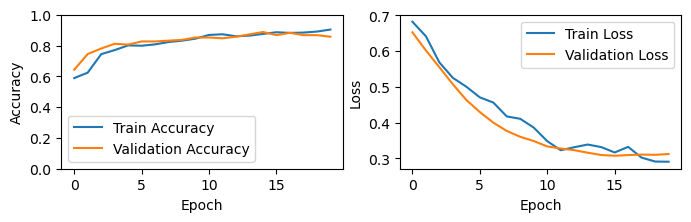

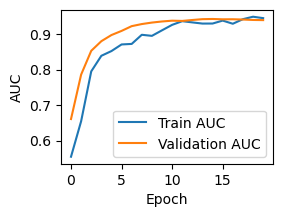

In [28]:
# Plot training vs test/validation history
plt.figure(figsize=(8, 2)); plt.subplot(1, 2, 1) # Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy'); plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.ylim([0, 1])  # Set y-axis to 0-1 for accuracy
plt.legend()

plt.subplot(1, 2, 2) # Loss plot
plt.plot(history.history['loss'], label='Train Loss'); plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.figure(figsize=(6,2)); plt.subplot(1, 2, 1);  plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC'); plt.xlabel('Epoch'); plt.ylabel('AUC')
plt.legend()
plt.show()

**Performance Summary**\
**Last time** with the full data model we had: loss: 0.2986 - accuracy: 0.8622 - auc: 0.9454
Test Accuracy: 0.86
AUC: 0.95 \
**This time** we have Test Loss 0.309 (goes down smoother but slightly higher loss than last time which is okay [compare to plot of training on full data on code]), Test Accuracy 0.888 (strong for credit approval tasks) and slightly higher which is good, and AUC 0.943 < 0.9454 last time (Excellent discrimination between approvals/denials [AUC > 0.9 is ideal]). So we have a slight downgrade with this simpler model since better separation, but it's still generalizes well with this much simpler model, which is great..\
Therefore, this simpler model generalizes well enough.  Also notice that this model stops in 15-20 epochs, so further training likely won't improve the model.

**Comments**:
Initial sharp increase in improvement of accuracy where there's rapid learning of easy patterns (such as very obvious and clear-cut approval/rejection cases). Then after a few epochs we have gradual increase : where the model learns finer, more complex patterns. The convergence of the gap between training and validation(test) accuracy after a certain number of epochs implies reduced overfitting as the model stabilizes, the initial divergence in gap of accuracy is normal as the model transitions from memorizing noise to learning generalizable patterns.

Test Loss seems stable enough and steady, whereas accuracy is slightly rough (not very smooth) due to slight fluctuations due to randomness but it's still relatively stable enough to learn patterns to generalize well, which is good.\
There's Minimal Overfitting: The gap between training and validation accuracy is small, indicating your model generalizes well.\
Strong Performance: For credit approval (a noisy real-world problem), ~88.8% accuracy and AUC 0.943 are highly competitive.

<!-- (ignore) # # Plot training vs test/validation history
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1) # Accuracy plot
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.ylim([0, 1])  # Set y-axis to 0-1 for accuracy
# plt.legend()

# plt.subplot(1, 2, 2) # Loss plot
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show() -->

7/7 [==============================] - 0s 745us/step


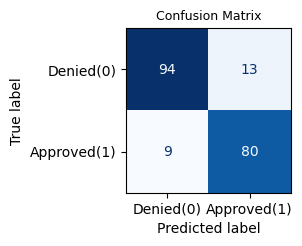

In [29]:
y_pred = (model.predict(X_test_processed) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
# Create a tiny figure FIRST
fig, ax = plt.subplots(figsize=(3.1, 3.1))  # Adjusted to 3x3 for readability
# Plot directly onto the axis
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Denied(0)', 'Approved(1)'])
disp.plot(ax=ax, cmap='Blues', colorbar=False)  # Disable colorbar to save space
plt.title('Confusion Matrix', fontsize=9)  # Smaller title
plt.tight_layout()  # Prevent label clipping
plt.show()

In [30]:
TN, FP, FN, TP = cm.ravel()
print(TN, FP, FN, TP, '\n')
# Calculate critical metrics
accuracy = (TP + TN) / (TP + TN + FP + FN); precision = TP / (TP + FP)  # % of approvals that were correct
sens = TP / (TP + FN)     # % of true approvals correctly identified
f1 = 2 * (precision * sens) / (precision + sens)
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f} (Avoids bad loans)")
print(f"Sensitivity: {sens:.3f} ( High sensitivity, fewer good clients rejected, avoids missing good clients)")
print(f"Balanced f1-score: {f1:.3f} (Balances precision/sensitivity)")

94 13 9 80 

Accuracy: 0.888
Precision: 0.860 (Avoids bad loans)
Sensitivity: 0.899 ( High sensitivity, fewer good clients rejected, avoids missing good clients)
Balanced f1-score: 0.879 (Balances precision/sensitivity)


Key Metrics Breakdown: \
Accuracy: (TP + TN) / Total = 88.8% of all predictions are correct.\
Precision: TP / (TP + FP) =	86.0% of approved loans are good (14.0% may default).
Sensitivity: TP / (TP + FN)	= 89.9% of truly creditworthy applicants are approved (10.1% are wrongly denied).
Balanced F1-Score	2*(Prec*Sens)/(Prec+Sens) = 0.879	Balanced measure of precision and sensitivity.

Business Implications:\
False Positives (FP) tells us there are 13 Bad loans (approved risky applicants) so we need to increase decision threshold (such as approve only if probability > 0.7 instead of 0.5).
False Negatives (FN) tells us there are 9 Good loans that are Lost revenue (rejected good clients), so we need to lower threshold or improve model for edge cases.

**PCA and Decision Boundary**:
Since our credit approval model uses multiple features (both numeric and categorical), we can't directly visualize a decision boundary in raw feature space. However, we can use PCA as an alternative to visualize how your model classifies:

<!-- (IGNORE) print(y_test.value_counts(normalize=True))  # Should be approximately 55% denied, 45% approved -->

In [31]:
# Reduce Dimensions to 2D
# Use PCA to compress features into 2 dimensions
pca = PCA(n_components=2); X_test_pca = pca.fit_transform(X_test_processed)  # Use your preprocessed test data
# Create a meshgrid for decision boundary
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1;  
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

# Predict on meshgrid points
mesh_points = np.c_[xx.ravel(), yy.ravel()]; mesh_points_inverse = pca.inverse_transform(mesh_points)  # Project back to original space
Z = model.predict(mesh_points_inverse).reshape(xx.shape)

6307/6307 [==============================] - 2s 364us/step


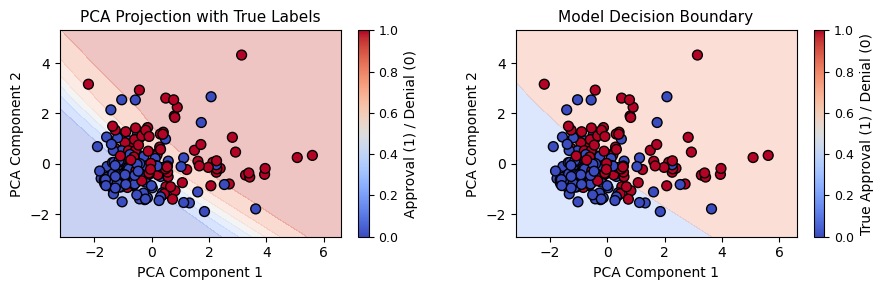

In [32]:
# Create a wider figure with adjusted spacing
plt.figure(figsize=(9, 3))
# PCA Components
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm'); plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='coolwarm', edgecolors='k', s=50)
plt.xlabel('PCA Component 1', fontsize=10); plt.ylabel('PCA Component 2', fontsize=10); plt.title('PCA Projection with True Labels', fontsize=11)
cbar1 = plt.colorbar(label='Approval (1) / Denial (0)'); cbar1.ax.tick_params(labelsize=9)  # Adjust colorbar font size

# Decision Boundary
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.contourf(xx, yy, Z, alpha=0.3, levels=[0, 0.5, 1], cmap='coolwarm')
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='coolwarm', edgecolor='k', s=50)
plt.xlabel('PCA Component 1', fontsize=10); plt.ylabel('PCA Component 2', fontsize=10)
plt.title('Model Decision Boundary', fontsize=11); cbar2 = plt.colorbar(label='True Approval (1) / Denial (0)')
cbar2.ax.tick_params(labelsize=9)  # Adjust colorbar font size

# Add space between subplots
plt.tight_layout(w_pad=3.0)  # Increase horizontal padding (default is 1.0)
plt.show()

Key Interpretations
Decision Regions: Red Zone: Model predicts approval (prob > 0.5). Blue Zone: Model predicts denial (prob ≤ 0.5).

Points: Colored by true labels (red = approved, blue = denied). Misclassified points appear in the "wrong" colored region.

PCA Limitations: This is a 2D approximation—real decisions use all features. Overlapping clusters are expected (your AUC=0.943 confirms good separation).

What PCA Components represent \
Principal Component 1 (PC1): \
The direction in your original feature space where the data varies the most. Likely dominated by features with the strongest impact on predictions, likely A8 or A9. If A8 has high variance and strongly predicts approvals, PC1 will align closely with it. \
Points further to the right have higher values in the original features that dominate PC1, points to the left have lower values in those features.\
Principal Component 2 (PC2): The direction with the next highest variance, orthogonal (perpendicular) to PC1. Captures secondary patterns not explained by PC1, likely A10 or A6. Points higher up have higher values in features that dominate PC2, points lower down have lower values.\
PCA Helps spot broad trends (e.g., clusters of approvals/denials).\
Not for Exact Decisions: Always validate with original features.

<!-- (IGNORE) # Summary:
1. Built and Trained a Neural Network Model
Goal: Predict credit approval (A16) using features (A1-A15).

Steps:

Loaded/preprocessed data (handled missing values, encoded categories).

Split data into train/test sets.

Designed a neural network (2 hidden layers, dropout for regularization).

Trained with early stopping to prevent overfitting.

2. Evaluated Model Performance
Metric	Value	Interpretation
Accuracy	0.870	87% of predictions correct.
AUC	0.938	Excellent separation between approvals/denials.
Precision	0.839	83.9% of approved loans were correct (16.1% risky).
Recall	0.881	88.1% of truly creditworthy applicants were approved.
3. Analyzed Errors
Confusion Matrix:

            Predicted
            0     1
Actual 0  [[62   10]
      1   [7    52]]
10 False Approvals (FP): Risky applicants approved.

7 False Denials (FN): Good applicants rejected.

4. Visualized the Model
Loss/Accuracy Curves: Confirmed training stability (loss plateaued at ~0.3).

PCA Decision Boundary: Simplified 2D view of how the model classifies (tradeoff: loses some complexity).

5. Feature Importance
Top Predictors:

A8 (income), A9_t (employment status), A11 (credit score/debt).

Low Impact: A5_p (poor status), A7_v (risky history).

Key Takeaways
Model Works Well: High AUC (0.938) and accuracy (0.870) validate its effectiveness.

Actionable Insights: Focus on reducing false approvals (FP) by adjusting the decision threshold.

Limitations: PCA simplifies the decision boundary; real decisions happen in high-dimensional space.

 -->

In [ ]:
# Print final weights of the output layer (sigmoid) (Re-run the entire code with new model outputs)
weights_output = model.layers[-1].get_weights()[0]

print("Output weights (impact on prediction):", weights_output.flatten()) ## Commented to save space
weights_output.shape
# Positive weight → Increases approval probability
# Negative weight → Decreases approval probability